## Implementation of "IMU calibration without mechanical equipment" by David Tedaldi

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from numba import jit

from scipy.optimize import least_squares

In [2]:
# load calibration dataset
df = pd.read_csv("./data/calibration.csv", encoding="UTF-8")
df.head()

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,50893847806400,107539,0.0479,-0.0072,-9.5904,0.0208,-0.0586,-0.0305,23.55
1,50893859576800,107550,0.0502,-0.0084,-9.5916,0.0208,-0.0586,-0.0293,23.51
2,50893870776200,107562,0.0502,-0.0048,-9.5880,0.0208,-0.0599,-0.0281,23.51
3,50893881701600,107573,0.0491,-0.0203,-9.5833,0.0195,-0.0599,-0.0281,23.57
4,50893893334800,107584,0.0479,-0.0191,-9.5713,0.0208,-0.0586,-0.0293,23.53


In [3]:
# create equal sampling rate

# Calculate the average time difference
average_time_difference = int((df['arduino_timestamp'].iloc[-1] - df['arduino_timestamp'].iloc[0]) / len(df))

# Create a new DataFrame with equal time intervals
new_time_column = pd.Series(range(df['arduino_timestamp'].iloc[0], df['arduino_timestamp'].iloc[-1] + 1, int(average_time_difference)))
new_df = pd.DataFrame({'arduino_timestamp': new_time_column})

# Merge the original DataFrame with the new DataFrame based on the time column
df = pd.merge_asof(new_df, df, on='arduino_timestamp')

# Interpolate the missing values
df = df.interpolate()

# Reset the index if needed
df = df.reset_index(drop=True)
df['arduino_timestamp'] = df['arduino_timestamp'] * 1e-3
df = df.rename(columns={'arduino_timestamp': 't'})
df = df.drop(['host_timestamp', 'temperature'], axis=1)
df.head()

,t,ax,ay,az,gx,gy,gz
0,107.539,0.0479,-0.0072,-9.5904,0.0208,-0.0586,-0.0305
1,107.550,0.0502,-0.0084,-9.5916,0.0208,-0.0586,-0.0293
2,107.561,0.0502,-0.0084,-9.5916,0.0208,-0.0586,-0.0293
3,107.572,0.0502,-0.0048,-9.5880,0.0208,-0.0599,-0.0281
4,107.583,0.0491,-0.0203,-9.5833,0.0195,-0.0599,-0.0281


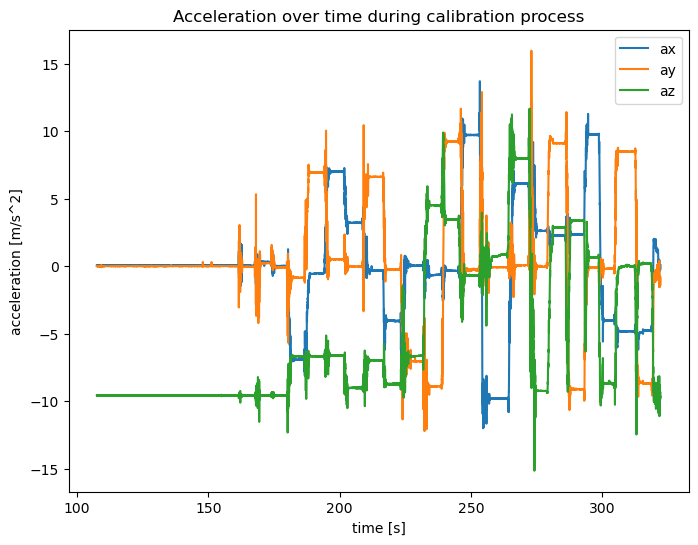

In [4]:
# plot acceleration

fig = plt.figure(figsize=(8, 6))

plt.plot(df.t, df.ax, label= 'ax')
plt.plot(df.t, df.ay, label= 'ay')
plt.plot(df.t, df.az, label= 'az')

# Adding labels and title
plt.xlabel('time [s]')
plt.ylabel('acceleration [m/s^2]')
plt.title('Acceleration over time during calibration process')
plt.legend()

# Display the plot
plt.show()

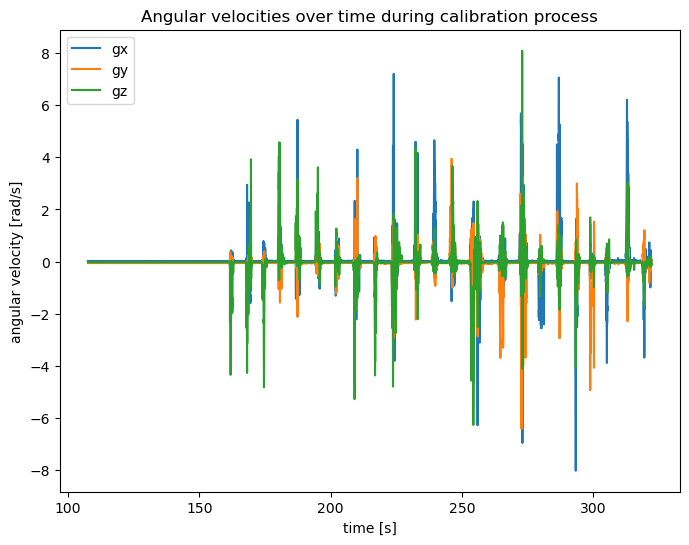

In [5]:
# plot angular velocity

fig = plt.figure(figsize=(8, 6))

plt.plot(df.t, df.gx, label= 'gx')
plt.plot(df.t, df.gy, label= 'gy')
plt.plot(df.t, df.gz, label= 'gz')


# Adding labels and title
plt.xlabel('time [s]')
plt.ylabel('angular velocity [rad/s]')
plt.title('Angular velocities over time during calibration process')
plt.legend()

# Display the plot
plt.show()

In [6]:
# determine end of intial static period
end_initial = (df[['gx', 'gy', 'gz']].sum(axis=1) > 0.1).idxmax()
end_initial

4957

#### Estimate gyroscope bias

In [7]:
# average gyroscope signal over T_init (the first ~50 seconds)

gx_mean = np.mean(df.iloc[:end_initial].gx)
gy_mean = np.mean(df.iloc[:end_initial].gy)
gz_mean = np.mean(df.iloc[:end_initial].gz)

print("The average angular velocity during static initialization period is {} (x), {} (y) and {} (z))".format(gx_mean, gy_mean, gz_mean))

The average angular velocity during static initialization period is 0.021069820455919416 (x), -0.0578713738148116 (y) and -0.045013173290299135 (z))


In [8]:
# substract bias from gyroscope signal

df.gx = df.gx - gx_mean
df.gy = df.gy - gx_mean
df.gz = df.gz - gx_mean


In [9]:
# initialize M_inf

M_inf = {}

In [10]:
time_span = df.loc[end_initial, "t"] - df.loc[0, "t"] 

print("The intialization static phase is {} sec long".format(time_span))



The intialization static phase is 54.527 sec long


In [11]:
# detect static intervals 

def static_detector(A, t_w, threshold):
    n = len(A)
    is_static = np.zeros(n, dtype=bool)

    for t in range(n):
        # Compute the start and end indices for the time span centered at t
        start = max(0, t - t_w // 2)
        end = min(n - 1, t + t_w // 2)

        # Compute variance magnitude for the buffered time span
        span = A[start : end + 1]
        variances = np.var(span, axis=0)
        variance_magnitude = np.sqrt(np.sum(variances ** 2))

        # Determine if the row corresponds to a static period based on the threshold
        is_static[t] = variance_magnitude <= threshold

    return is_static

In [12]:
# plot acceleration with static periods

def plot_acceleration_with_static_periods(df, is_static):

    fig = plt.figure(figsize=(16, 6))

    integer_values = is_static.astype(int)
    plt.plot(df.t, integer_values, zorder=1)

    plt.plot(df.t, df.ax, label= 'ax', alpha = 0.5, zorder=2)
    plt.plot(df.t, df.ay, label= 'ay', alpha = 0.5, zorder=3)
    plt.plot(df.t, df.az, label= 'az', alpha = 0.5, zorder=4)


    # Adding labels and title
    plt.xlabel('time [s]')
    plt.ylabel('acceleration [m/s^2]')
    plt.title('Acceleration and static periods')
    plt.legend()
    plt.savefig('static_periods.png')
    # Display the plot
    plt.show()

In [13]:
# optimize eq. 3.4  using static_intervals and a^s averaging with t_w

g = [0,0,9.81]
acc_s = np.stack((df.ax, df.ay, df.az), axis=1)

# function to correct acceleration data based on params
def h(acc_s, params):

    # orthogonalization
    a_yz = params[0]
    a_zy = params[1]
    a_zx = params[2]

    # scaling
    s_x = params[3]
    s_y = params[4]
    s_z = params[5]

    # bias
    b_x = params[6]
    b_y = params[7]
    b_z = params[8]

    T = np.eye(3)
    T[0,1] = -a_yz
    T[0,2] = a_zy
    T[1,2] = -a_zx

    K = np.diag([s_x,s_y,s_z])

    a_O = T @ K @ (acc_s + [b_x, b_y, b_z])
    
    # return orthogonalized, bias-corrected and scaled acceleration data
    return a_O


def loss_acc(params, *acc_s):
    N = len(acc_s)
    residuals = []
    for i in range(N):
        residuals.append((np.linalg.norm(g) - np.linalg.norm(h(acc_s[i], params))) ** 2)

    return residuals

# mask is provided by static detector
def get_static_periods(mask):
    indices = []
    current_chunk = []
    prev_value = 1
    for i, value in enumerate(mask):
        if value == 1:
            current_chunk.append(i)
        if int(prev_value) - int(value) == 1:
            indices.append(current_chunk)
            current_chunk = []
        prev_value = value
    return indices


# compute mean for each static period
def compute_mean_for_static_periods(df, is_static, t_w):
    prev = 1
    start = 0
    indices = []
    for i in range(len(df)):
        if int(is_static[i]) == 1 and prev == 0:
            start = i
        elif int(is_static[i]) == 0 and prev == 1:
            end = i
            indices.append([start,end])
        prev = int(is_static[i])

    means = []

    for start, end in indices:
        chunk = df[start:end]
        if len(chunk) >= t_w:
            num_windows = len(chunk) // t_w
            for j in range(num_windows):
                start_idx = j * t_w
                end_idx = start_idx + t_w
                window_chunk = chunk[start_idx:end_idx]
                ax_mean = window_chunk['ax'].mean()
                ay_mean = window_chunk['ay'].mean()
                az_mean = window_chunk['az'].mean()
                means.append([ax_mean, ay_mean, az_mean])
        else:
            ax_mean = chunk['ax'].mean()  
            ay_mean = chunk['ay'].mean()
            az_mean = chunk['az'].mean()
            means.append([ax_mean,ay_mean,az_mean])

    means = np.vstack(means)

    return means


In [14]:
# square of variance magnitude computed over T_init
#threshold = np.n(np.sum(np.var(df.iloc[:idx_end][['ax', 'ay','az']], axis= 0)))
sum_of_squared_variances = np.var(df.iloc[:end_initial]['ax'], axis= 0)**2 + np.var(df.iloc[:end_initial][ 'ay'], axis= 0)**2 + np.var(df.iloc[:end_initial]['az'], axis= 0)**2
threshold = np.sqrt(sum_of_squared_variances)

# use t_w = 1 [s] as in the paper
t_w = int(1 / 0.011) # compute how many time steps account to 1 s

# initliaziation for optimization as described in the paper
params = np.array([0,0,0,1,1,1,0,0,0])

k = 40 

for i in range(30,k): # choose the interval 20-30 through observation of the resulting static periods
    
    curr_threshold = i * np.square(threshold)

    is_static = static_detector(A=df[['ax', 'ay', 'az']], t_w=t_w, threshold= curr_threshold )
    #curr_df = df[is_static]


    #curr_acc = curr_df[['ax', 'ay','az']].to_numpy()
    curr_acc = compute_mean_for_static_periods(df, is_static, t_w)

    res = least_squares(loss_acc, params, method='lm', args=curr_acc)

    # store residual, params (optimal solution), threshold, static intervals
    M_inf[i-30] = [res.cost, res.x, curr_threshold, is_static]

In [15]:
# find index of M_inf with smallest residual
values = [M_inf[key][0] for key in list(M_inf.keys())]
i_smallest = np.argmin(values)


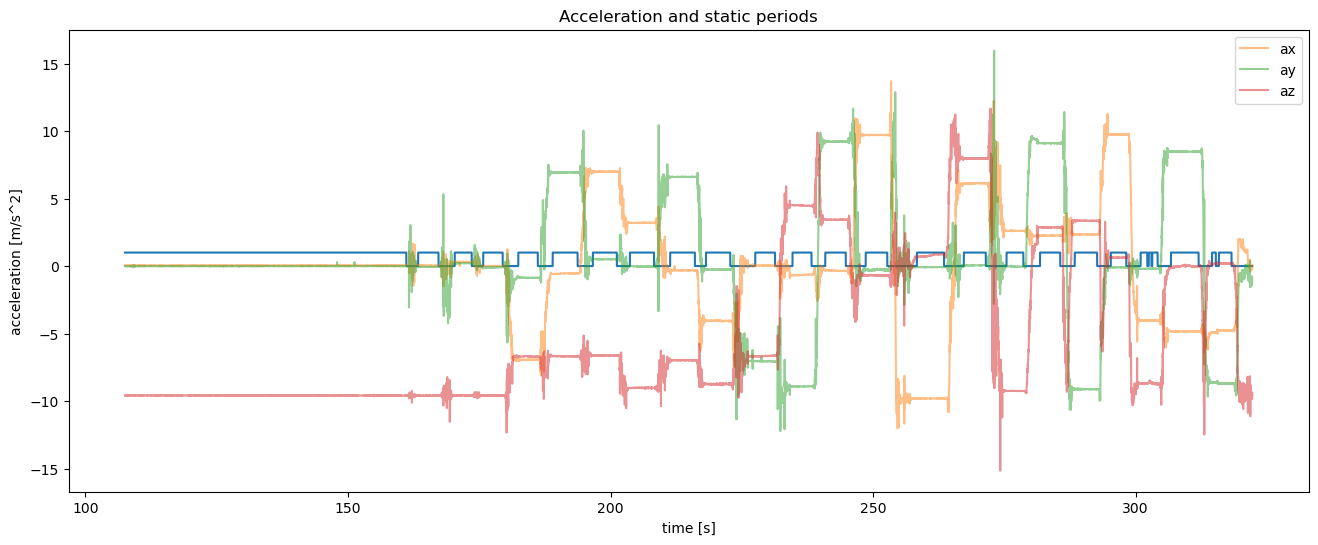

In [16]:
# get params from the above chosen M-inf

params = M_inf[i_smallest][1]

# get static intervals from the above chosen M-inf

is_static = M_inf[i_smallest][3]
plot_acceleration_with_static_periods(df, is_static)

In [17]:
print("The orhogonalization parameters are: {}".format(params[:3]))
print("The scaling parameters are: {}".format(params[3:6]))
print("The bias parameters are: {}".format(params[6:]))

The orhogonalization parameters are: [ 0.00345148  0.00414667 -0.0038719 ]
The scaling parameters are: [1.00003429 0.99810256 0.99453758]
The bias parameters are: [ 0.02770738  0.06370465 -0.28430919]


In [18]:
# calibrate a^s with those params

df[['ax_c', 'ay_c', 'az_c']] = df[['ax', 'ay', 'az']].apply(lambda row: pd.Series(h(row, params)), axis=1)


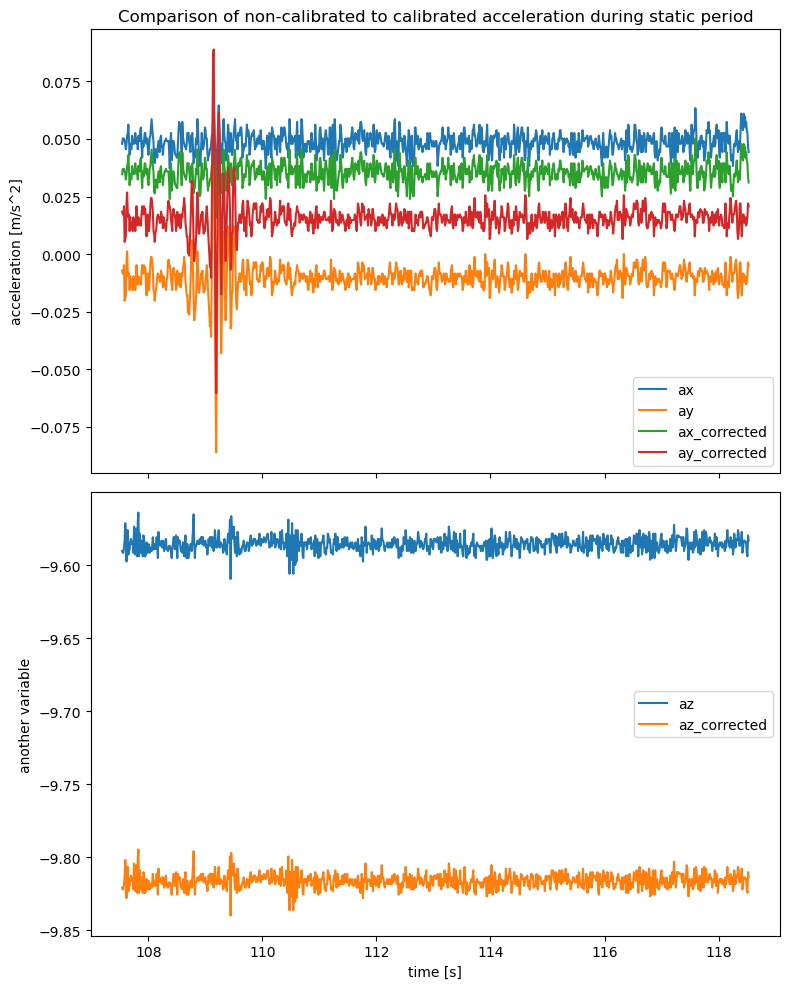

In [19]:
# plot acceleration
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot for the first set of data
ax1.plot(df[:1000].t, df[:1000].ax, label='ax')
ax1.plot(df[:1000].t, df[:1000].ay, label='ay')
ax1.plot(df[:1000].t, df[:1000].ax_c, label='ax_corrected')
ax1.plot(df[:1000].t, df[:1000].ay_c, label='ay_corrected')

ax1.set_ylabel('acceleration [m/s^2]')
ax1.set_title('Comparison of non-calibrated to calibrated acceleration during static period')
ax1.legend()

# Plot for the second set of data
ax2.plot(df[:1000].t, df[:1000].az, label='az')  
ax2.plot(df[:1000].t, df[:1000].az_c, label='az_corrected')
ax2.set_xlabel('time [s]')
ax2.set_ylabel('another variable')
ax2.legend()

# Adjust spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

In [23]:
#optimize Eq. 3.8, using static_intervals, w_s bias free and a_o averaging with t_wait

params_found = []
cost = []

def compute_mean_for_static_periods_corrected(df, is_static):
    prev = 1
    start = 0
    indices = []
    for i in range(len(df)):
        if int(is_static[i]) == 1 and prev == 0:
            start = i
        elif int(is_static[i]) == 0 and prev == 1:
            end = i
            indices.append([start,end])
        prev = int(is_static[i])

    return indices

def corrected_gyr(w_i, u_0):

    y_yz = u_0[0]
    y_zy = u_0[1]
    y_xz = u_0[2]
    y_zx = u_0[3]
    y_xy = u_0[4]
    y_yx = u_0[5]

    Y = np.identity(3)
    Y[0,1] = -y_yz
    Y[0,2] = y_zy
    Y[1,2] = -y_zx
    Y[1,0] = y_xz
    Y[2,0] = -y_xy
    Y[2,1] = y_yx

    # scaling paramaters
    S = np.diag(u_0[6:9])


    g_O = Y @ S @ w_i
    return g_O

def rotation_matrix(q):
    w = q[..., 0]
    x = q[..., 1]
    y = q[..., 2]
    z = q[..., 3]
    R = np.zeros((*q.shape[:-1], 3, 3), dtype=q.dtype)
    R[..., 0, 0] = 1 - 2 * (y * y + z * z)
    R[..., 0, 1] = 2 * (x * y - z * w)
    R[..., 0, 2] = 2 * (x * z + y * w)
    R[..., 1, 0] = 2 * (x * y + z * w)
    R[..., 1, 1] = 1 - 2 * (x * x + z * z)
    R[..., 1, 2] = 2 * (y * z - x * w)
    R[..., 2, 0] = 2 * (x * z - y * w)
    R[..., 2, 1] = 2 * (y * z + x * w)
    R[..., 2, 2] = 1 - 2 * (x * x + y * y)
    return R

@jit(nopython=True)
def G(g):
    shape = g.shape[:-1]
    gx = g[..., 0]
    gy = g[..., 1]
    gz = g[..., 2]
    G = np.zeros((*shape, 4, 4), dtype=g.dtype)
    G[..., 0, 1] = -gx
    G[..., 0, 2] = -gy
    G[..., 0, 3] = -gz
    G[..., 1, 0] = gx
    G[..., 1, 2] = gz
    G[..., 1, 3] = -gy
    G[..., 2, 0] = gy
    G[..., 2, 1] = -gz
    G[..., 2, 3] = gx
    G[..., 3, 0] = gz
    G[..., 3, 1] = gy
    G[..., 3, 2] = -gx
    return G

@jit(nopython=True)
def integrate_rk4(t, g_s):
    
    n, _ = g_s.shape
    q_sn = np.empty((n, 4))
    
    G_s = G(g_s)
    
    q_sn[0] = 1.0, 0.0, 0.0, 0.0
    
    for i in range(1, n):
        dt = t[i] - t[i - 1]
        
        G_s_half = 0.5 * (G_s[i - 1] + G_s[i])
        
        k1 = 0.5 * G_s[i - 1] @  q_sn[i - 1]
        k2 = 0.5 * G_s_half   @ (q_sn[i - 1] + 0.5 * dt * k1)
        k3 = 0.5 * G_s_half   @ (q_sn[i - 1] + 0.5 * dt * k2)
        k4 = 0.5 * G_s[i]     @ (q_sn[i - 1] +       dt * k3)
        
        q_sn[i] = q_sn[i - 1] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        
        norm = np.sqrt(np.sum(q_sn[i] * q_sn[i]))
        q_sn[i] /= norm
    
    return q_sn

def compute_gravity_vec_based_on_acc(acc):
    return acc[i]


def computeAccVector(gyr_s, initial_acc_vector, t):  
    q_sn_rk4 = integrate_rk4(t, gyr_s)
    R_sn_rk4 = rotation_matrix(q_sn_rk4)
    acc_vectors = np.matmul(R_sn_rk4, initial_acc_vector)

    return acc_vectors


def loss_gyro(params, gyr_s, acc_O, t, df, is_static):
    indices = compute_mean_for_static_periods_corrected(df, is_static)
    N = len(indices)
    residuals = np.empty(N)
    initial_acc_vector = np.array([0,0,9.81])
    gyr_s_c = np.apply_along_axis(corrected_gyr, axis=1, arr=gyr_s, u_0= params)

    acc_vectors = np.array(computeAccVector(gyr_s_c, initial_acc_vector, t))
    i = 0

    # iterate over static periods
    for start, end in indices:
        chunk = acc_O[start:end]
        ax_mean = np.mean(chunk[:,0])
        ay_mean =np.mean( chunk[:,1])
        az_mean = np.mean(chunk[:,2])
        residuals[i] = np.linalg.norm([ax_mean,ay_mean,az_mean] - np.mean(acc_vectors[start:end])) # mean of acc_vectors instead of acc_mean repeated
        i += 1

    cost.append(residuals)
    params_found.append(params)
    return residuals


In [39]:
# initliaziation for optimization as described in the paper
# full scale of gyroscope is +-2000 dps => 34.9 rad/s
# as resolution for A/D Converter we assume 12 = log2(2*2000)
#initial_guess = 1 / ((2** 12 - 1)/2 * 34.9)
initial_guess = 1
print("Our intial guess for the scaling parameters is {}".format(initial_guess))
params = np.array([0,0,0,0,0,0,initial_guess,initial_guess,initial_guess])


acc = df[['ax_c', 'ay_c','az_c']].to_numpy()
gyr = df[['gx', 'gy','gz']].to_numpy()
t = df[['t']].to_numpy()



res = least_squares(loss_gyro, params, method='lm', args=(gyr,acc, t, df, is_static), verbose=1, max_nfev=1000)

# store residual, params (optimal solution), threshold, static intervals
residuals = res.cost
parameters = res.x


Our intial guess for the scaling parameters is 1
The maximum number of function evaluations is exceeded.
Function evaluations 1008, initial cost 2.6453e+03, final cost 1.0818e+03, first-order optimality 1.09e+02.


In [44]:
print("The orhogonalization parameters are: {}".format(parameters[:6]))
print("The scaling parameters are: {}".format(parameters[6:]))

The orhogonalization parameters are: [ -3.85927973   2.15328637  -1.33520229   0.08763791 -10.26480552
  -1.0848148 ]
The scaling parameters are: [ 0.67254447  1.57702048 -0.71886704]


Text(0.5, 1.0, 'Scaling parameters optimization with least squares')

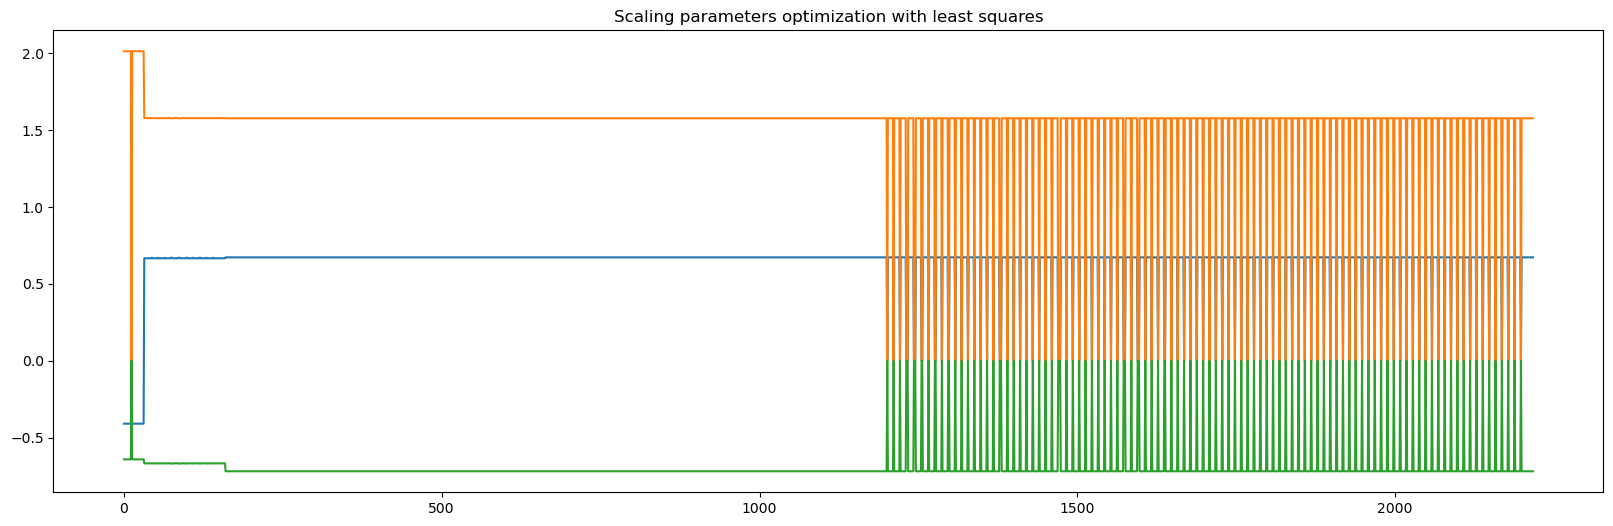

In [53]:
fig = plt.figure(figsize=(20, 6))
plt.plot(range(len(params_found)), [x[6] for x in params_found])
plt.plot(range(len(params_found)), [x[7] for x in params_found])
plt.plot(range(len(params_found)), [x[8] for x in params_found])
plt.title("Scaling parameters optimization with least squares")

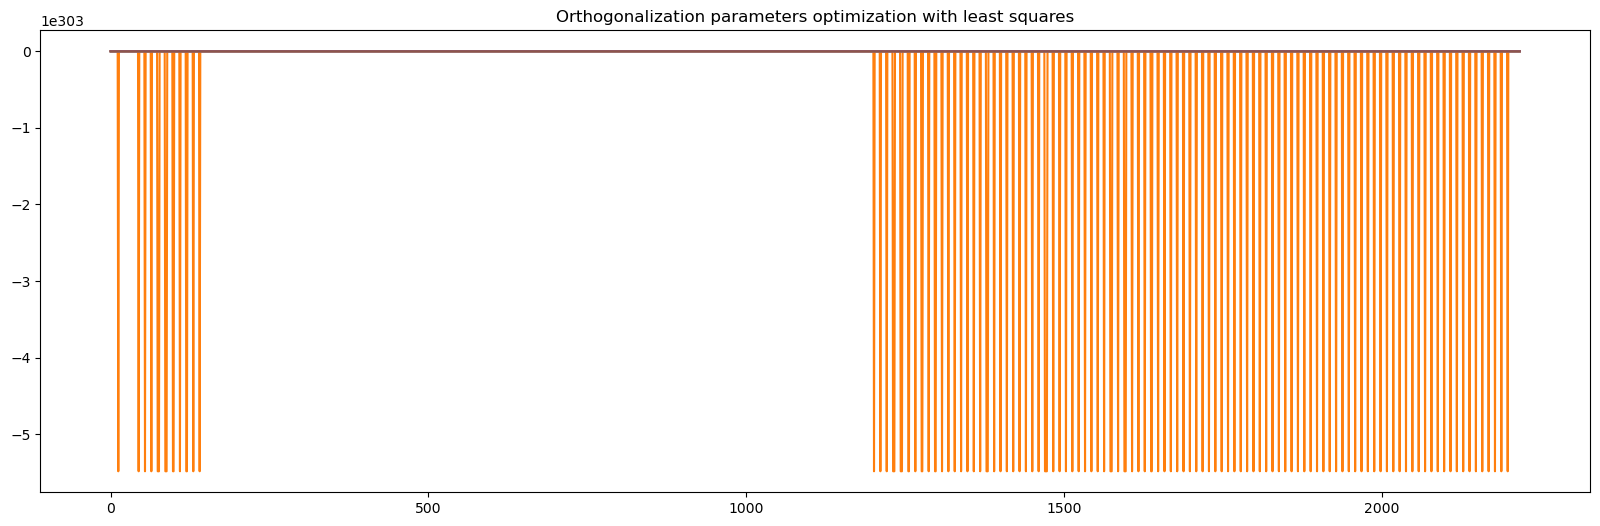

In [54]:
fig = plt.figure(figsize=(20, 6))
plt.plot(range(len(params_found)), [x[0] for x in params_found])
plt.plot(range(len(params_found)), [x[1] for x in params_found])
plt.plot(range(len(params_found)), [x[2] for x in params_found])
plt.plot(range(len(params_found)), [x[3] for x in params_found])
plt.plot(range(len(params_found)), [x[4] for x in params_found])
plt.plot(range(len(params_found)), [x[5] for x in params_found])
plt.title("Orthogonalization parameters optimization with least squares")
plt.show()

We observe that the values are not converging.

In [56]:
# correct gyroscope data
gyr_s_c = np.apply_along_axis(corrected_gyr, axis=1, arr=gyr, u_0= parameters)

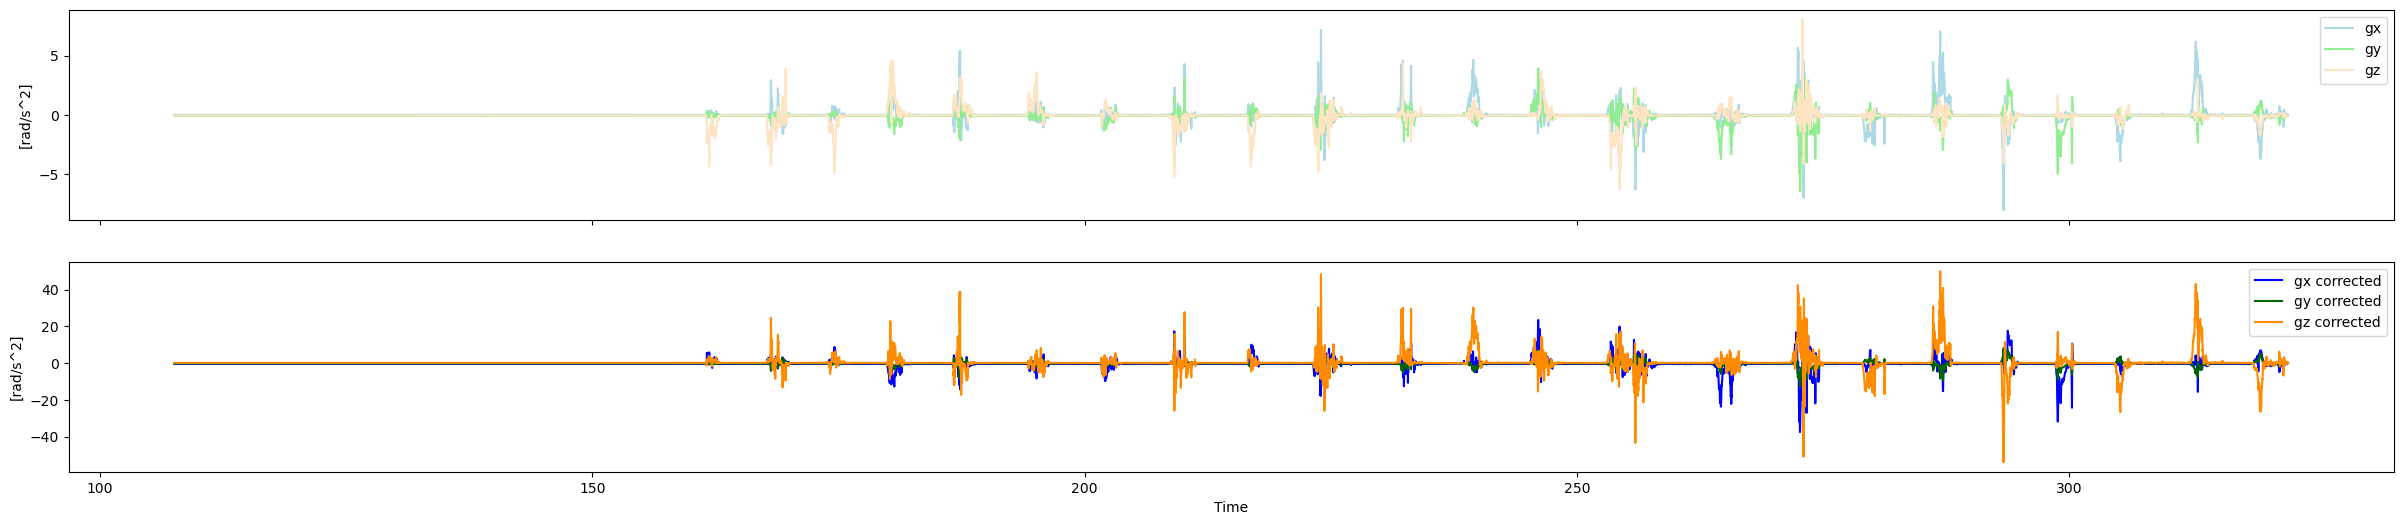

In [67]:
# Create a figure and axis objects

fig, ax = plt.subplots(2, sharex=True, figsize=(30, 6))

time = df.t

# Plot the gyroscope data
ax[0].plot(time, df.gx, label='gx', c = "lightblue")
ax[0].plot(time, df.gy, label='gy', c= "lightgreen")
ax[0].plot(time, df.gz, label='gz', c = "bisque")
ax[1].plot(time, gyr_s_c[:,0], label='gx corrected', c = "blue")
ax[1].plot(time, gyr_s_c[:,1], label='gy corrected', c= "darkgreen")
ax[1].plot(time, gyr_s_c[:,2], label='gz corrected', c= "darkorange")

# Set the labels and title
plt.xlabel('Time')
ax[0].set_ylabel('[rad/s^2]')
ax[1].set_ylabel('[rad/s^2]')

# Add a legend
ax[0].legend()
ax[1].legend()

# Show the plot
plt.show()